Processing data/stereo/captures/raiz_apriltags_camaramovil/left_0.jpg and data/stereo/captures/raiz_apriltags_camaramovil/right_0.jpg
Detected tag 0, hamming: 0, goodness: 0.0, decision_margin: 68.65048217773438
Detected tag 6, hamming: 0, goodness: 0.0, decision_margin: 86.29733276367188
Detected tag 7, hamming: 0, goodness: 0.0, decision_margin: 92.98246765136719
Detected tag 0, hamming: 0, goodness: 0.0, decision_margin: 65.51333618164062
Detected tag 7, hamming: 0, goodness: 0.0, decision_margin: 81.41199493408203


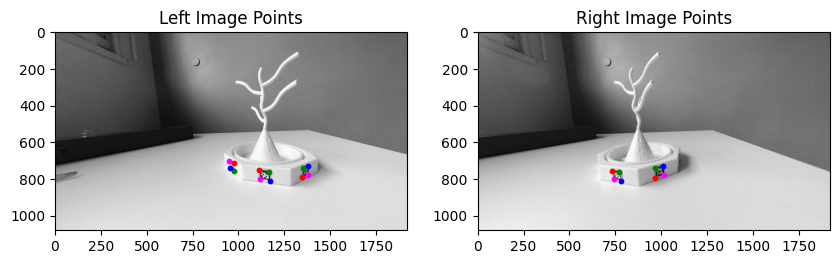

In [ ]:
import os

import numpy as np
import cv2
import open3d as o3d

from apriltags.detect_apriltags import detect_apriltags
from disparity.disp import get_disparity_method, compute_disparity
from utils.utils import read_pickle
from utils.images import prepare_imgs, process_images

################## SETUP

datasets_path = "data/stereo"

calib_stereo_file = os.path.join(datasets_path, "stereo_calibration.pkl")
undistort_maps_file = os.path.join(datasets_path, "stereo_maps.pkl")

captures_dir = "data/stereo/captures/raiz_apriltags_camaramovil"
rectified_dir = "data/stereo/captures/rect_raiz_apriltags_camaramovil"


################ RECONSTRUCTION

# input images
input_dir = captures_dir

# Known object to detect in images
tag_family = "tag25h9"

# read calibration files
calibration = read_pickle(calib_stereo_file)
maps = read_pickle(undistort_maps_file)

# separate calibration params
left_K = calibration["left_K"]
left_dist = calibration["left_dist"]
right_K = calibration["right_K"]
right_dist = calibration["right_dist"]
image_size = calibration["image_size"]
T = calibration["T"]

left_map_x = maps["left_map_x"]
left_map_y = maps["left_map_y"]
right_map_x = maps["right_map_x"]
right_map_y = maps["right_map_y"]
P1 = maps["P1"]
P2 = maps["P2"]
Q = maps["Q"]

# baseline in mm as x-axis distance from left to right camera
baseline_mm = T[0]

# configures model, defines disparity method and returns calibration object
method = get_disparity_method(
        image_size,
        P1[0,0], P1[1,1], P1[0,2], P2[0,2], P1[1,2],
        baseline_meters = baseline_mm / 1000,
        method_name = "OpenCV_SGBM"  # or "OpenCV_BM", "OpenCV_SGBM", "CREStereo"
    )

left_file_names, right_file_names = prepare_imgs(input_dir)

all_points_3d = np.empty((0, 3))
all_colors = np.empty((0, 3))
all_camera_extrinsics = []
export_num = 0

for left_file_name, right_file_name in zip([left_file_names[0]], [right_file_names[0]]):
        print(f"Processing {left_file_name} and {right_file_name}")

        image_size, left_color, right_color = process_images(left_file_name, right_file_name, image_size)
        left_image = cv2.cvtColor(left_color, cv2.COLOR_BGR2GRAY)
        right_image = cv2.cvtColor(right_color, cv2.COLOR_BGR2GRAY)
        
        left_size = (left_image.shape[1], left_image.shape[0])
        right_size = (right_image.shape[1], right_image.shape[0])

        # rectify images
        left_image_rectified = cv2.remap(left_image, left_map_x, left_map_y, cv2.INTER_LINEAR)
        right_image_rectified = cv2.remap(right_image, right_map_x, right_map_y, cv2.INTER_LINEAR)

        ######### POSE ##################

        left_object_points, left_image_points = detect_apriltags(left_image_rectified,tag_family)
        right_object_points, right_image_points = detect_apriltags(right_image_rectified, tag_family)

        import matplotlib.pyplot as plt

        # Plot image points in left image
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        colors = ['red', 'green', 'blue', 'magenta']
        
        # Plot image points in left image
        plt.imshow(left_image_rectified, cmap='gray')
        for i, point in enumerate(left_image_points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], marker='o', s=10)
        plt.title('Left Image Points')

        # Plot image points in right image
        plt.subplot(1, 2, 2)
        plt.imshow(right_image_rectified, cmap='gray')
        for i, point in enumerate(right_image_points):
            plt.scatter(point[0], point[1], c=colors[i % len(colors)], marker='o', s=10)
        plt.title('Right Image Points')

        plt.show()

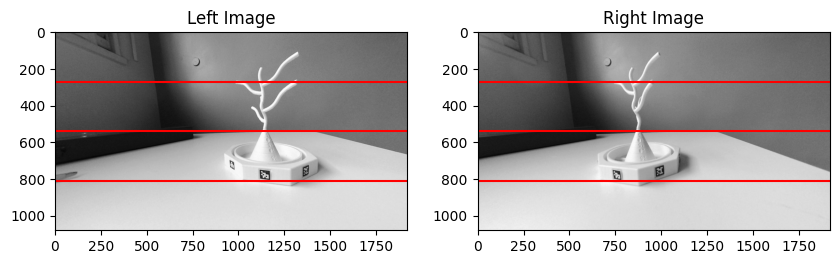

In [7]:
# CHECKING RECTIFICATION

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Define y values for the horizontal lines
y_values = [left_image_rectified.shape[0] // 4, left_image_rectified.shape[0] // 2, 3 * left_image_rectified.shape[0] // 4]

# Plot left image with multiple horizontal lines
axes[0].imshow(left_image_rectified, cmap='gray')
axes[0].set_title('Left Image')
for y in y_values:
    axes[0].axhline(y=y, color='red', linestyle='-')

# Plot right image with multiple horizontal lines
axes[1].imshow(right_image_rectified, cmap='gray')
axes[1].set_title('Right Image')
for y in y_values:
    axes[1].axhline(y=y, color='red', linestyle='-')

plt.show()